root
 |-- Transaction ID: integer (nullable = true)
 |-- Date: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Age Group: string (nullable = true)
 |-- Product Category: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- Price per Unit: integer (nullable = true)
 |-- Total Amount: integer (nullable = true)

+--------------+----------+------+---+----------+----------------+--------+--------------+------------+
|Transaction ID|      Date|Gender|Age| Age Group|Product Category|Quantity|Price per Unit|Total Amount|
+--------------+----------+------+---+----------+----------------+--------+--------------+------------+
|             1|11/24/2023|  Male| 34|Middle Age|          Beauty|       3|            50|         150|
|             2| 2/27/2023|Female| 26|Adolescent|        Clothing|       2|           500|        1000|
|             3| 1/13/2023|  Male| 50|Middle Age|     Electronics|       1|            30|     

+------------+--------------+
|Customer_Key|Customer Sales|
+------------+--------------+
|   Female_34|         12050|
|   Female_26|         10375|
|   Female_43|         10260|
|     Male_51|          8795|
|     Male_22|          8275|
|     Male_31|          8200|
|     Male_63|          8045|
|   Female_18|          7940|
|     Male_43|          7710|
|     Male_46|          7710|
+------------+--------------+
only showing top 10 rows



+----+-----+-------------+
|Year|Month|Monthly Sales|
+----+-----+-------------+
|NULL| NULL|        95410|
|2023|    1|        25550|
|2023|    2|        30080|
|2023|    3|        20950|
|2023|    4|        17265|
|2023|    5|        42555|
|2023|    6|        28630|
|2023|    7|        29400|
|2023|    8|        24435|
|2023|    9|        15535|
|2023|   10|        46580|
|2023|   11|        34920|
|2023|   12|        44690|
+----+-----+-------------+



/var/folders/13/ss70nyl50tz6m7p_sj1p05yh0000gn/T/ipykernel_91972/6683390.py:96: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=product_sales_pd, x="Total Sales", y="Product Category", palette="viridis")


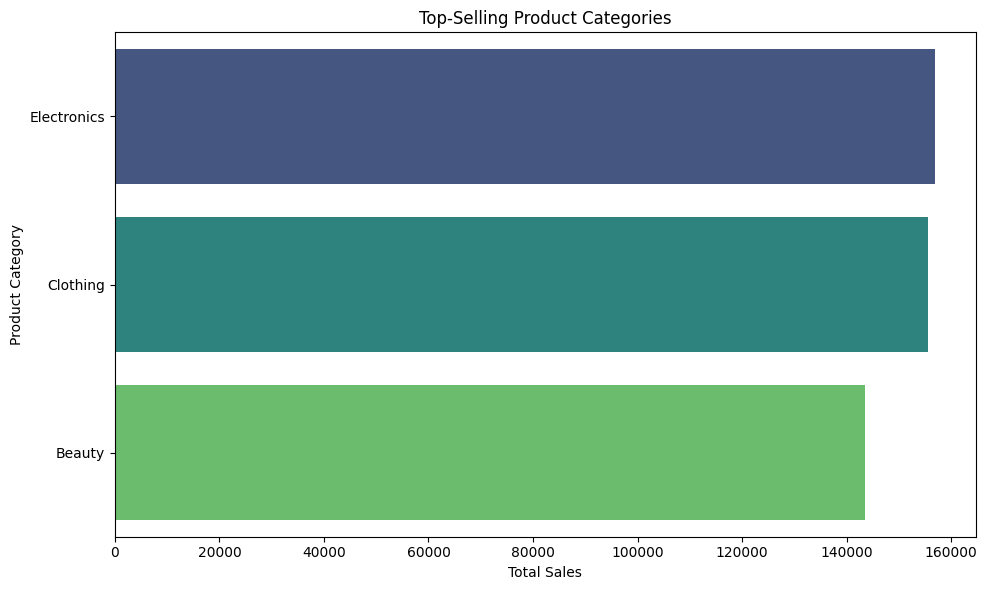

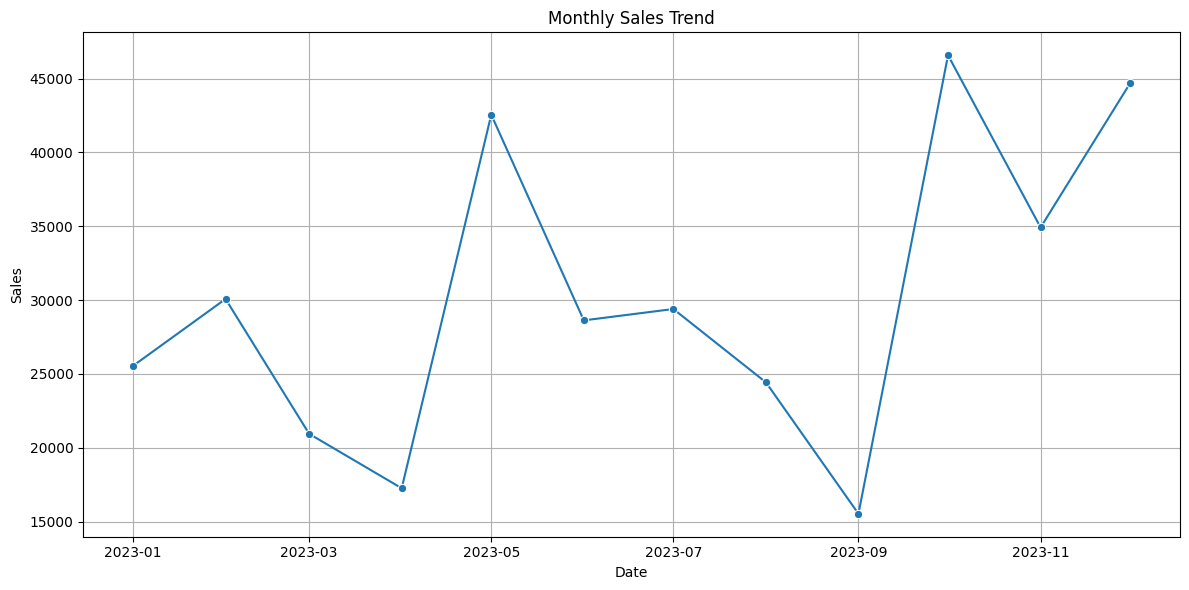

25/04/21 00:04:08 WARN CacheManager: Asked to cache already cached data.


'\n- **Top-Selling Categories**: The most revenue comes from specific product categories which can be targeted more in promotions.\n- **Customer Segments**: Gender and Age combinations can help create personalized campaigns.\n- **Monthly Trends**: Helps forecast demand and plan inventory for peak months.\n- **Recommendation**: Increase stock for high-selling items during peak months. Consider age-gender-based discounts.\n'

In [ ]:
# Retail Sales Analysis using Apache Spark

## 1. Setup & Load Dataset

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql.functions import to_date, year, month
from pyspark.sql.functions import month, year
from pyspark.sql.functions import when, length, to_date, col

# Create Spark session
spark = SparkSession.builder \
    .appName("Retail Sales Analysis") \
    .getOrCreate()

# Load dataset with header and inferSchema
file_path = "/Users/gyandeep/OSTDS_assignment_5/Retail Sales Data Set.csv"
df_raw = spark.read.option("header", True).option("inferSchema", True).csv(file_path)

# Select only the required columns immediately (Option 2 logic)
columns_to_keep = [
    "Transaction ID", "Date", "Gender", "Age", "Age Group",
    "Product Category", "Quantity", "Price per Unit", "Total Amount"
]
df = df_raw.select(*columns_to_keep)

df.printSchema()
df.show(5)

## 2. Data Cleaning

# Drop duplicates
df = df.dropDuplicates()

# Drop rows with too many missing values
threshold = 0.75 * len(df.columns)
df = df.dropna(thresh=int(threshold))
df.show(5)

## 3. Data Transformation



# Normalize dates to always have 2-digit years
df = df.withColumn("NormalizedDate", 
    when(length(col("Date")) - length(regexp_replace(col("Date"), "/", "")) == 2,  # 2 slashes = 3 parts
         when(length(col("Date")) > 8, col("Date"))  # Already yyyy, leave as is
         .otherwise(  # Add '20' prefix to 2-digit year
             regexp_replace(col("Date"), r'(\d+/\d+)/(\d+)$', r'\1/20\2')
         )
    )
)

# Then parse using yyyy format
df = df.withColumn("ParsedDate", to_date("NormalizedDate", "M/d/yyyy"))


df = df.withColumn("Month", month("ParsedDate"))
df = df.withColumn("Year", year("ParsedDate"))


## 4. Data Analysis

# Total Sales per Product
product_sales = df.groupBy("Product Category") \
                .agg(sum("Total Amount").alias("Total Sales")) \
                .orderBy(desc("Total Sales"))
product_sales.show()

# Synthetic Customer Key from Gender + Age
df = df.withColumn("Customer_Key", concat_ws("_", col("Gender"), col("Age")))

# Total Sales per Customer Key
customer_sales = df.groupBy("Customer_Key") \
                 .agg(sum("Total Amount").alias("Customer Sales")) \
                 .orderBy(desc("Customer Sales"))
customer_sales.show(10)

# Monthly Sales Trend
monthly_sales = df.groupBy("Year", "Month") \
                .agg(sum("Total Amount").alias("Monthly Sales")) \
                .orderBy("Year", "Month")
monthly_sales.show()

## 5. Visualization (Using Pandas + Matplotlib/Seaborn)

# Convert to Pandas for plotting
product_sales_pd = product_sales.toPandas()
monthly_sales_pd = monthly_sales.toPandas()
customer_sales_pd = customer_sales.toPandas()

# Plot top product categories
plt.figure(figsize=(10,6))
sns.barplot(data=product_sales_pd, x="Total Sales", y="Product Category", palette="viridis")
plt.title("Top-Selling Product Categories")
plt.xlabel("Total Sales")
plt.ylabel("Product Category")
plt.tight_layout()
plt.show()

# Monthly sales trend
plt.figure(figsize=(12,6))
monthly_sales_pd['Date'] = pd.to_datetime(monthly_sales_pd[['Year', 'Month']].assign(DAY=1))
sns.lineplot(data=monthly_sales_pd, x="Date", y="Monthly Sales", marker="o")
plt.title("Monthly Sales Trend")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.tight_layout()
plt.show()

## 6. Performance Optimization (Basic Techniques)

# Cache data for reuse
df.cache()

# Repartition for parallel processing
optimized_df = df.repartition("Product Category")

## 7. Insights & Recommendations

'''
- **Top-Selling Categories**: The most revenue comes from specific product categories which can be targeted more in promotions.
- **Customer Segments**: Gender and Age combinations can help create personalized campaigns.
- **Monthly Trends**: Helps forecast demand and plan inventory for peak months.
- **Recommendation**: Increase stock for high-selling items during peak months. Consider age-gender-based discounts.
'''
